<a href="https://colab.research.google.com/github/sp9103/Neural-Style/blob/master/Neural_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    %tensorflow_version 1.x
except:
    pass

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as plt
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import imageio
from functools import reduce

In [3]:
tf.__version__

'1.15.2'

# Upload content Image

Saving 13B63EE8-6BAC-4DFB-8FB2-2D8B0FA062E6_1_201_a.jpeg to 13B63EE8-6BAC-4DFB-8FB2-2D8B0FA062E6_1_201_a.jpeg
content img : 13B63EE8-6BAC-4DFB-8FB2-2D8B0FA062E6_1_201_a.jpeg


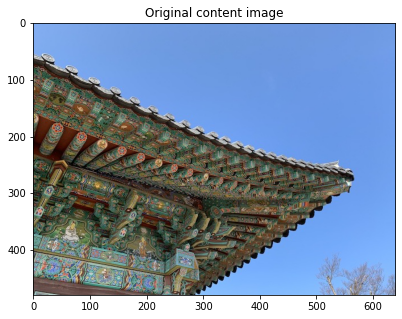

In [4]:
from google.colab import files
uploaded = files.upload()
CONTENT_PATH = list(uploaded.keys())[-1]
print('content img : ' + CONTENT_PATH)

raw_content = imageio.imread(CONTENT_PATH)
plt.figure(0, figsize=(10, 5))
plt.imshow(raw_content)
plt.title("Original content image")
plt.show()

# Define VGG Net

In [5]:
def net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0,1))
    weights = data['layers'][0]
    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current
    assert len(net) == len(layers)
    return net, mean_pixel, layers
def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1,1,1,1), padding='SAME')
    return tf.nn.bias_add(conv, bias)
def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
def preprocess(image, mean_pixel):
    return image - mean_pixel
def unprocess(image, mean_pixel):
    return image + mean_pixel
def imread(path):
    return imageio.imread(path).astype(np.float)
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)

In [6]:
!wget http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

--2020-06-27 15:59:31--  http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat [following]
--2020-06-27 15:59:31--  https://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 576042600 (549M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 549.36M  17.9MB/s    in 31s     

2020-06-27 16:00:03 (17.6 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [576042600/576042600]



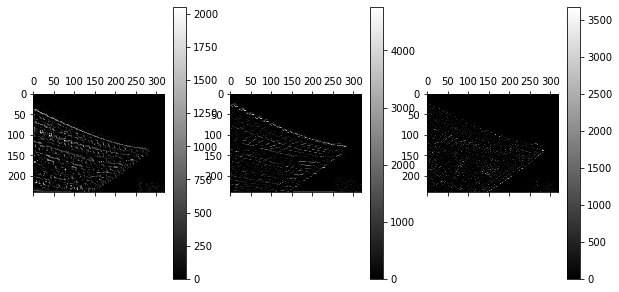

In [7]:
VGG_PATH = '/content/imagenet-vgg-verydeep-19.mat'
CONTENT_LAYER = 'relu2_2'
STYLE_LAYERS  = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

content_image = raw_content.astype(np.float)
content_shape = (1,) + content_image.shape # (h, w, nch) =>  (1, h, w, nch)

with tf.Session() as sess:
    image = tf.placeholder('float', shape=content_shape)
    nets, content_mean_pixel, _ = net(VGG_PATH, image)
    content_image_pre = np.array([preprocess(content_image, content_mean_pixel)])
    content_features = nets[CONTENT_LAYER].eval(feed_dict={image: content_image_pre})

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    for i in range(3):
        im = axes[i].matshow(content_features[0, :, :, i], cmap=plt.cm.gray)
        fig.colorbar(im, ax=axes[i])

    plt.show()


In [26]:
!wget -O style.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/290px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

--2020-06-27 16:22:53--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/290px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35417 (35K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>]  34.59K  --.-KB/s    in 0.001s  

2020-06-27 16:22:54 (28.0 MB/s) - ‘style.jpg’ saved [35417/35417]



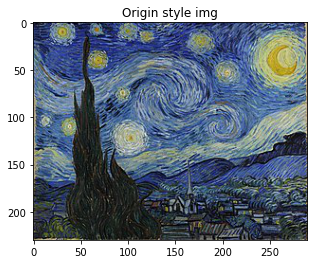

In [27]:
STYLE_PATH = '/content/style.jpg'
raw_style = imageio.imread(STYLE_PATH,)
plt.figure(0)
plt.imshow(raw_style)
plt.title("Origin style img")
plt.show()

In [28]:
style_image = raw_style.astype(np.float)
style_shape = (1,) + style_image.shape
style_features = dict()

with tf.Session() as sess:
    image = tf.placeholder('float', shape=style_shape)
    nets, _, _ = net(VGG_PATH, image)
    style_image_pre = np.array([preprocess(style_image, content_mean_pixel)])
    for idx, layer in enumerate(STYLE_LAYERS):
        curr_features = nets[layer].eval(feed_dict={image: style_image_pre})
        curr_features_vec = np.reshape(curr_features, (-1, curr_features.shape[3]))
        gram = np.matmul(curr_features_vec.T, curr_features_vec) / curr_features_vec.size
        style_features.update({layer: gram})

# Style transfer

[0/1000]


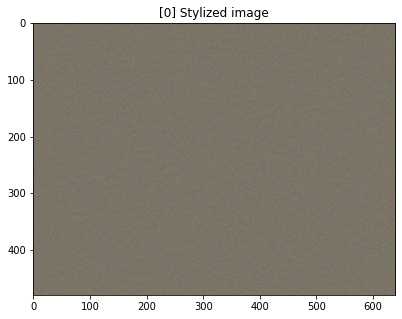

[100/1000]


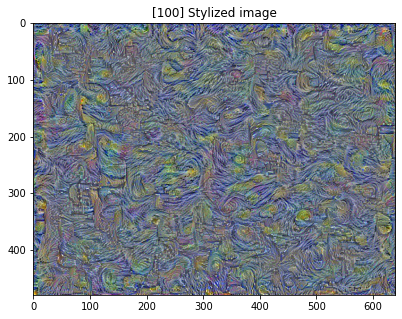

[200/1000]


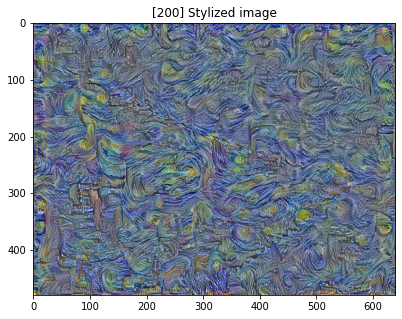

[300/1000]


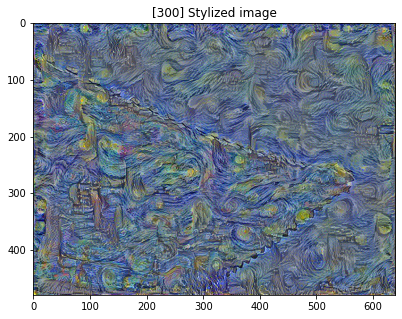

[400/1000]


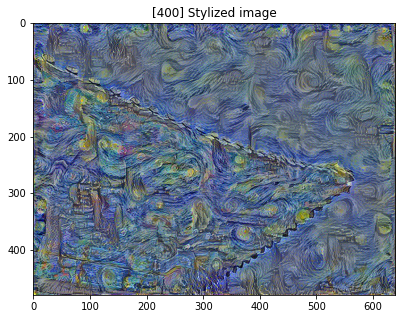

[500/1000]


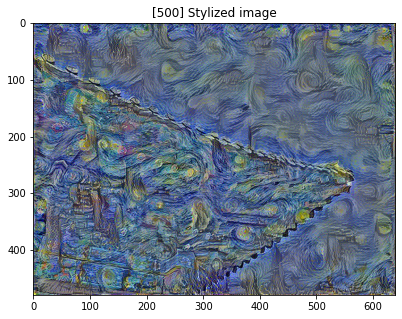

[600/1000]


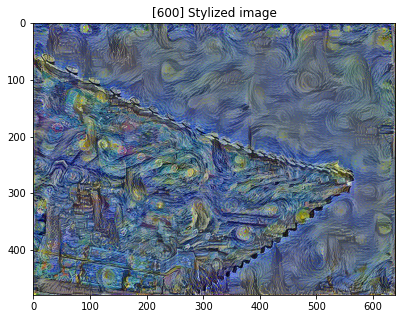

[700/1000]


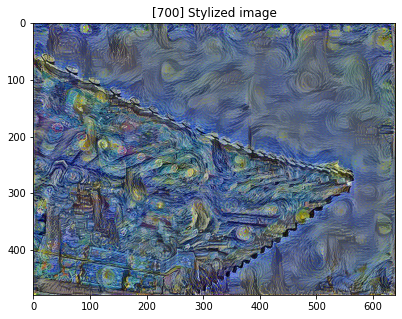

[800/1000]


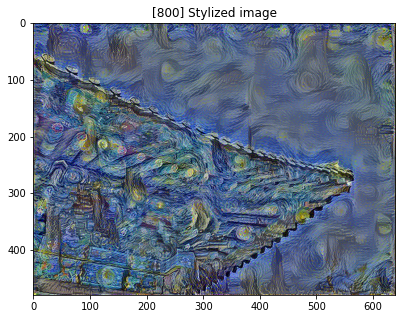

[900/1000]


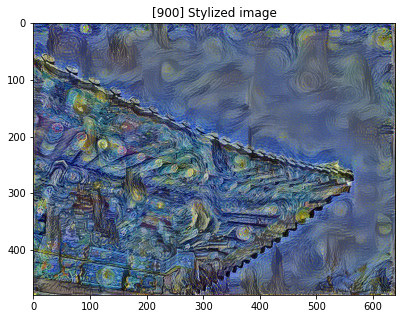

[999/1000]


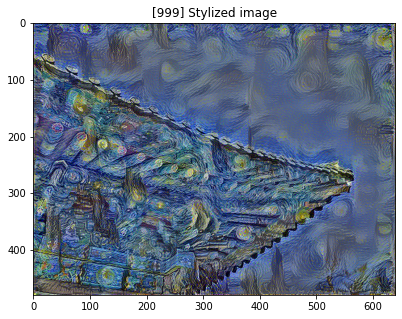

In [29]:
content_weight = 1
style_weight = 10
learning_rate = 5.
iterations = 1000

def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

with tf.Session() as sess:
    initial = tf.random_normal(content_shape) * 0.256
    image2opt = tf.Variable(initial)
    nets, mea_pixel, _ = net(VGG_PATH, image2opt)

    content_loss = content_weight * (2 * tf.nn.l2_loss(nets[CONTENT_LAYER] - content_features) / content_features.size)

    style_losses = []
    for style_layer in STYLE_LAYERS:
        layer = nets[style_layer]
        _, height, width, channel = layer.get_shape()
        size = height * width * channel
        feats = tf.reshape(layer, (-1, channel.value))
        gram = tf.matmul(tf.transpose(feats), feats) / size.value
        style_gram = style_features[style_layer]
        style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
    style_loss = style_weight * reduce(tf.add, style_losses)

    loss = content_loss + style_loss
    
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    sess.run(tf.initialize_all_variables())
    for i in range(iterations):
        sess.run(opt)
        if i % 100 == 0 or i == iterations - 1:
            print("[%d/%d]" %(i, iterations))
            out = image2opt.eval()
            
            stylized_img = unprocess(out[0, :, :, :], content_mean_pixel)
            stylized_img = np.clip(stylized_img, 0, 255).astype('uint8')
            plt.figure(0, figsize=(10, 5))
            plt.imshow(stylized_img)
            plt.title("[%d] Stylized image" % (i))
            plt.show()